In [284]:
import pandas as pd

data= pd.read_parquet('D:\\traffic_forecasting\\Data\\yellow_tripdata_2024-01.parquet')

In [285]:
data = data.dropna(subset=['passenger_count', 'trip_distance', 'fare_amount'])

In [286]:
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

In [287]:
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['pickup_day_of_week'] = data['tpep_pickup_datetime'].dt.dayofweek
data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
data['distance_per_minute'] = data['trip_distance'] / (data['trip_duration'] + 1e-5)  # Avoid division by zero



In [288]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [289]:
data['is_airport_trip'] = data['Airport_fee'] > 0

In [290]:
# Create a new feature to flag refund or cancellation transactions
data['is_refund'] = data['total_amount'].apply(lambda x: 1 if x < 0 else 0)

# Check the distribution of is_refund
print(data['is_refund'].value_counts())


is_refund
0    2788960
1      35502
Name: count, dtype: int64


In [291]:
data['airport_distance_interaction'] = data['Airport_fee'] * data['trip_distance']

In [292]:
#Bins should be more and labels should be one less 
bins= [0,25,50,75,100,500]
labels= ['0-25','26-50','51-75','75-100','100+']
data['fare_bucket']= pd.cut(data['fare_amount'], bins=bins, labels=labels)
print(data['fare_bucket'].value_counts())

fare_bucket
0-25      2284139
26-50      320934
51-75      153197
75-100      22060
100+         7861
Name: count, dtype: int64


In [293]:
data['is_airport_trip']= data['is_airport_trip'].astype(int)

In [333]:
data.columns 

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'trip_duration',
       'pickup_hour', 'pickup_day_of_week', 'pickup_month',
       'distance_per_minute', 'is_airport_trip', 'is_refund',
       'airport_distance_interaction', 'fare_bucket'],
      dtype='object')

In [366]:
asd=data[data['total_amount']<0]
print('this is the length of the negative fare_amount ', len(asd))

this is the length of the negative fare_amount  35502


In [365]:
asd=data[data['fare_amount']<0]
print('this is the length of the negative fare_amount ', len(asd))

this is the length of the negative fare_amount  35382


In [373]:
columns_for_use=['trip_distance','PULocationID','DOLocationID',
                 'fare_amount','total_amount','Airport_fee', 'pickup_hour','pickup_day_of_week','is_airport_trip','is_refund']

df= data[columns_for_use]


In [341]:
cor_data=data[columns_for_use].corr()
print(cor_data)

                      trip_distance  PULocationID  DOLocationID  fare_amount  \
trip_distance              1.000000     -0.052387     -0.036625     0.298587   
PULocationID              -0.052387      1.000000      0.084237    -0.117382   
DOLocationID              -0.036625      0.084237      1.000000    -0.080853   
fare_amount                0.298587     -0.117382     -0.080853     1.000000   
total_amount               0.304008     -0.117895     -0.075631     0.979421   
Airport_fee                0.237170     -0.158072     -0.051316     0.571233   
pickup_hour               -0.000052      0.010497      0.024336    -0.002025   
pickup_day_of_week        -0.006611     -0.017055     -0.017067    -0.021575   
congestion_surcharge      -0.093102      0.121503      0.112219    -0.136358   
is_airport_trip            0.243775     -0.163611     -0.054214     0.558039   
is_refund                 -0.001998     -0.010245     -0.010311    -0.224037   

                      total_amount  Air

In [374]:
X = df.drop(columns=['fare_amount'])  # All columns except the target
y = df['fare_amount']  # The target variable

In [375]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [376]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [377]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum depth of a tree
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

# Fit the model
xgb_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_reg.predict(X_test_scaled)

# Evaluate
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 23.53837502305789
R²: 0.940535372305501


In [218]:
# fare_bucket_dist = df['fare_bucket'].value_counts(normalize=True) * 100
# print(fare_bucket_dist)


In [219]:
# bucket_analysis = df.groupby('fare_bucket').agg({
#     'trip_distance': ['mean', 'median'],
#     'pickup_hour': 'mean',
#     'PULocationID': pd.Series.mode,
#     'DOLocationID': pd.Series.mode,
# }).reset_index()
# print(bucket_analysis)


In [36]:
high_fare_data = df[df['fare_bucket'].isin(['76-100', '100+'])]
print(high_fare_data.describe())


           VendorID  trip_distance  PULocationID  DOLocationID   fare_amount  \
count  29921.000000   29921.000000  29921.000000  29921.000000  29921.000000   
mean       1.843454      17.563684    147.425821    139.508305    102.541528   
std        0.363378      11.468259     53.032845    104.276098     41.178898   
min        1.000000       0.000000      1.000000      1.000000     75.050000   
25%        2.000000      14.000000    132.000000     25.000000     82.800000   
50%        2.000000      18.920000    132.000000    138.000000     88.800000   
75%        2.000000      23.200000    163.000000    259.000000    101.000000   
max        2.000000     210.820000    265.000000    265.000000    500.000000   

              extra       mta_tax  total_amount   Airport_fee   pickup_hour  \
count  29921.000000  29921.000000  29921.000000  29921.000000  29921.000000   
mean       0.965426      0.239130    125.389955      0.827011     13.871528   
std        1.716706      0.249768     47.4

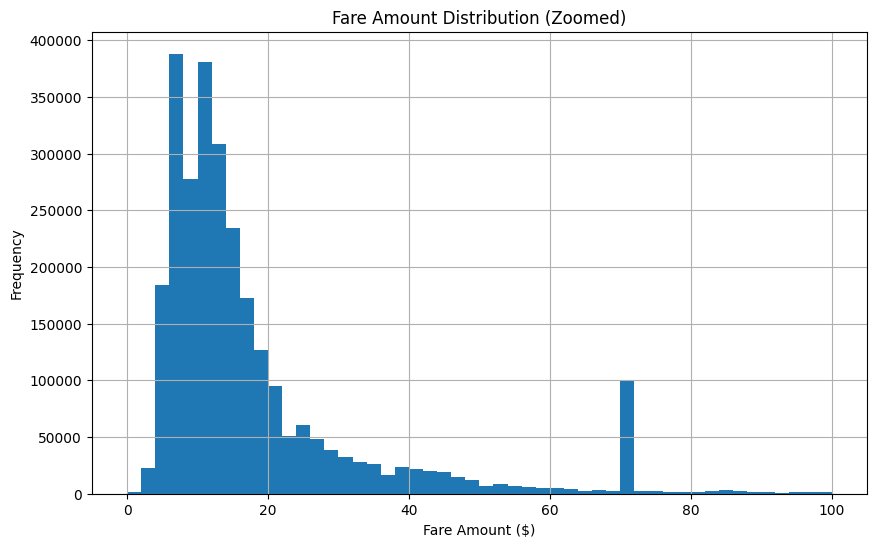

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['fare_amount'].hist(bins=50, range=(0, 100))  # Adjust range for focus
plt.title('Fare Amount Distribution (Zoomed)')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()


In [30]:
short_fares = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= 25)]
print(short_fares.describe())


           VendorID  trip_distance  PULocationID  DOLocationID   fare_amount  \
count  2.284982e+06   2.284982e+06  2.284982e+06  2.284982e+06  2.284982e+06   
mean   1.752659e+00   1.644858e+00  1.702682e+02  1.689814e+02  1.197701e+01   
std    4.314665e-01   1.222922e+00  6.414534e+01  6.727142e+01  4.937998e+00   
min    1.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    2.000000e+00   9.000000e-01  1.400000e+02  1.370000e+02  7.900000e+00   
50%    2.000000e+00   1.400000e+00  1.630000e+02  1.630000e+02  1.140000e+01   
75%    2.000000e+00   2.160000e+00  2.360000e+02  2.360000e+02  1.490000e+01   
max    2.000000e+00   9.718000e+02  2.650000e+02  2.650000e+02  2.500000e+01   

              extra       mta_tax  total_amount   Airport_fee   pickup_hour  \
count  2.284982e+06  2.284982e+06  2.284982e+06  2.284982e+06  2.284982e+06   
mean   1.364166e+00  4.986072e-01  1.922141e+01  1.384464e-02  1.427158e+01   
std    1.462760e+00  2.714642e-02  6.15285

In [31]:
medium_fares = df[(df['fare_amount'] >= 70) & (df['fare_amount'] <= 80)]
print(medium_fares.describe())


            VendorID  trip_distance   PULocationID   DOLocationID  \
count  107484.000000  107484.000000  107484.000000  107484.000000   
mean        1.824476      17.430054     140.854332     152.459761   
std         0.380416      33.867801      37.895926      66.648750   
min         1.000000       0.000000       1.000000       1.000000   
25%         2.000000      17.050000     132.000000     116.000000   
50%         2.000000      17.980000     132.000000     142.000000   
75%         2.000000      19.190000     132.000000     229.000000   
max         2.000000   10879.280000     265.000000     265.000000   

         fare_amount          extra        mta_tax   total_amount  \
count  107484.000000  107484.000000  107484.000000  107484.000000   
mean       70.466051       1.540713       0.489384      92.911683   
std         1.709290       2.359548       0.072975       8.964889   
min        70.000000      -2.500000       0.000000      70.000000   
25%        70.000000       0.0000

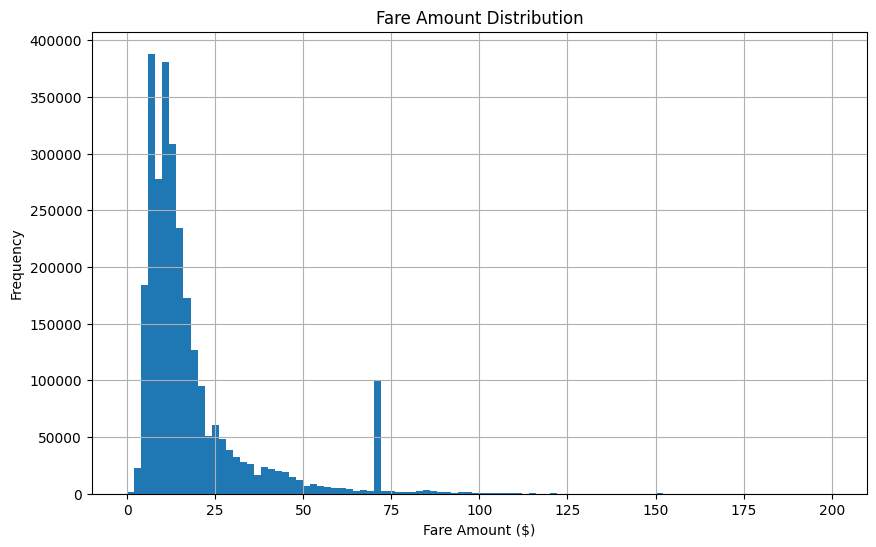

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['fare_amount'].hist(bins=100, range=(0, 200))  # Focus on lower range
plt.title('Fare Amount Distribution')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()


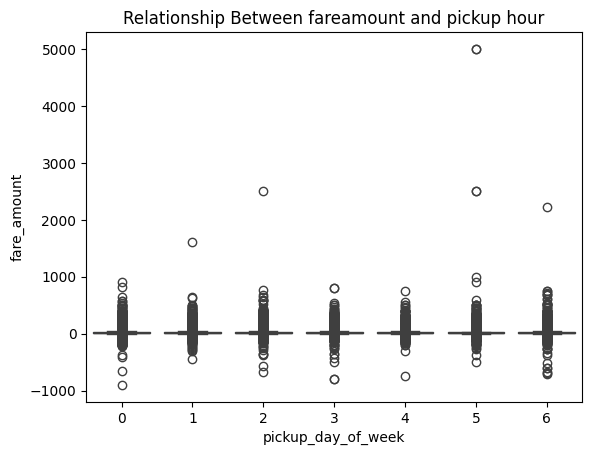

In [16]:
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.boxplot(x='pickup_day_of_week', y='fare_amount', data=df)
plt.title("Relationship Between fareamount and pickup hour")
plt.show()

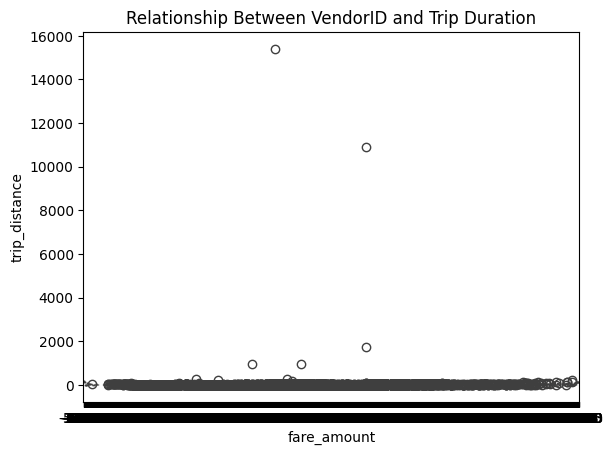

In [277]:
sns.boxplot(x='fare_amount', y='trip_distance', data=df)
plt.title("Relationship Between VendorID and Trip Duration")
plt.show()

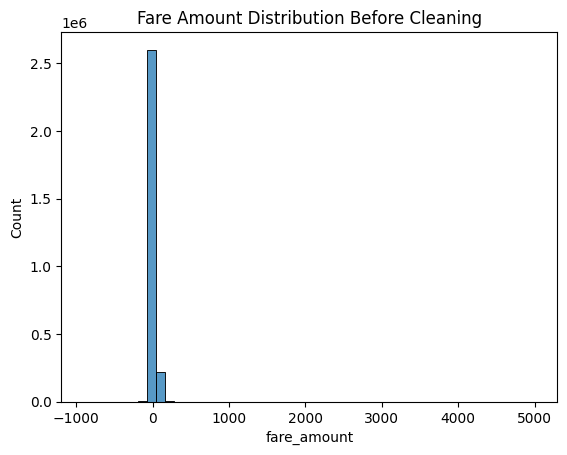

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distribution of fare_amount before cleaning
sns.histplot(df['fare_amount'], bins=50)
plt.title("Fare Amount Distribution Before Cleaning")
plt.show()

# Visualize distribution of fare_amount after cleaning (removing negatives)
# sns.histplot(df_cleaned['fare_amount'], bins=50)
# plt.title("Fare Amount Distribution After Cleaning")
# plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

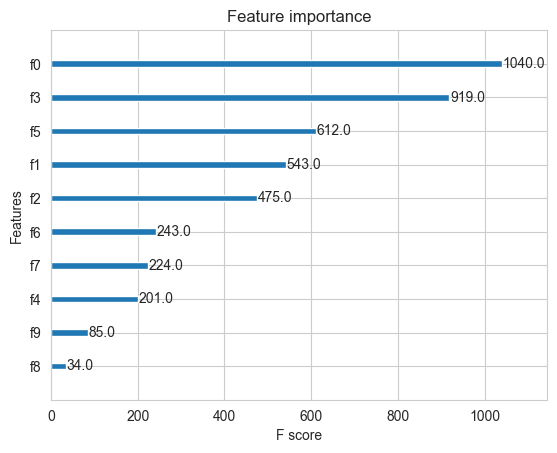

In [372]:
from xgboost import plot_importance
plot_importance(xgb_reg)  # Visualize feature importance


In [283]:
import numpy as np
import pandas as pd

def detect_outliers_iqr(df, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Return rows where the data is outside of the bounds
    return df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]

outliers_trip_distance = detect_outliers_iqr(df, 'trip_distance')
outliers_fare_amount = detect_outliers_iqr(df, 'fare_amount')
# Apply to other columns as needed


In [284]:
from scipy import stats

def detect_outliers_zscore(df, column_name, threshold=3):
    z_scores = stats.zscore(df[column_name])
    return df[np.abs(z_scores) > threshold]

outliers_trip_distance_z = detect_outliers_zscore(df, 'trip_distance')
outliers_fare_amount_z = detect_outliers_zscore(df, 'fare_amount')
# Apply to other columns as needed


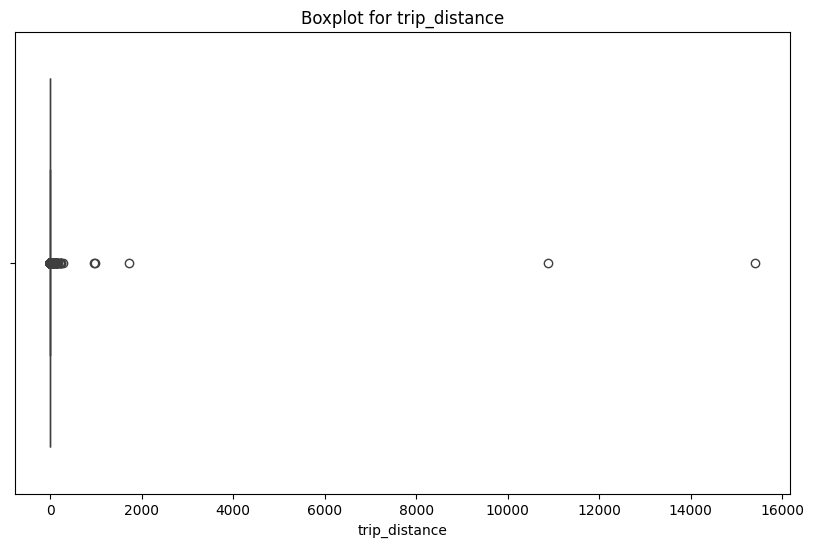

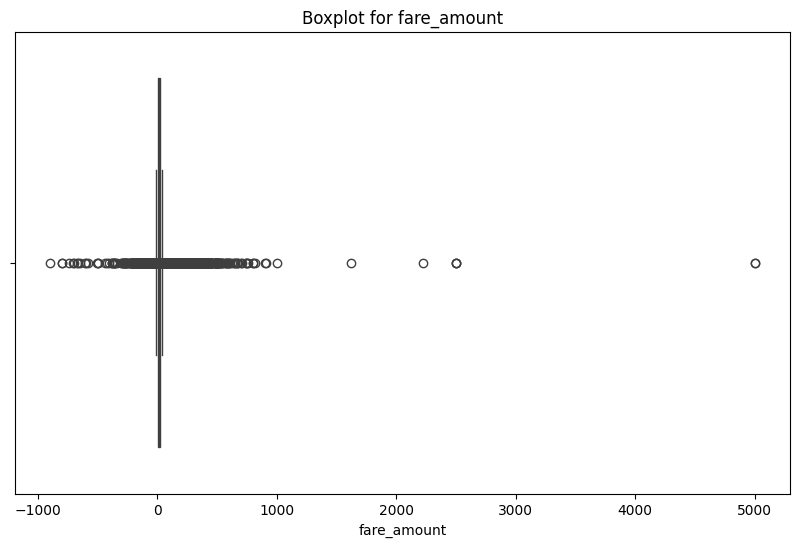

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplot(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column_name])
    plt.title(f'Boxplot for {column_name}')
    plt.show()

plot_boxplot(df, 'trip_distance')
plot_boxplot(df, 'fare_amount')


In [286]:
!pip install --upgrade scikit-learn xgboost


  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/a1/a6/c5b78606743a1f28eae8f11973de6613a5ee87366796583fb74c67d54939/scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/70/58/2f94976df39470fb00eec2cb4f914dde44cd0df8d96483208bf7db4bc97e/xgboost-2.1.3-py3-none-win_amd64.whl.metadata
  Using cached xgboost-2.1.3-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
Using cached xgboost-2.1.3-py3-none-win_amd64.whl (124.9 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully 


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [287]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),  # New instance of XGBRegressor
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE for scoring
    n_jobs=-1  # Utilize all CPUs
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score (neg MSE):", grid_search.best_score_)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

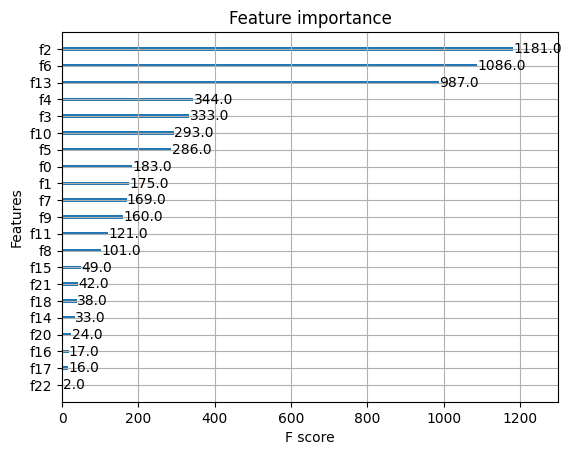

In [188]:
from xgboost import plot_importance
plot_importance(xgb_reg)  # Visualize feature importance


In [ ]:
# from sklearn.linear_model import LinearRegression
# model= LinearRegression()
# model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(random_state=42)
# model.fit(X_train_scaled, y_train)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Calculate RMSE and R^2
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")


RMSE: 1104.3350306778834
R^2: 0.06740944108491398
